In [64]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
import os
import sscCdi

def create_2d_gaussian(N, M, sigma_x, sigma_y, mu_x=None, mu_y=None):
    """
    Creates a 2D Gaussian distribution matrix.

    Parameters:
    - N: Number of rows.
    - M: Number of columns.
    - sigma_x: Standard deviation in the x direction.
    - sigma_y: Standard deviation in the y direction.
    - mu_x: Mean in the x direction. Defaults to the center of the matrix if not provided.
    - mu_y: Mean in the y direction. Defaults to the center of the matrix if not provided.

    Returns:
    A 2D array representing the Gaussian distribution.
    """
    if mu_x is None:
        mu_x = N / 2
    if mu_y is None:
        mu_y = M / 2

    x = np.linspace(0, N-1, N)
    y = np.linspace(0, M-1, M)
    x, y = np.meshgrid(x, y)

    gaussian = np.exp(-(((x - mu_x) ** 2) / (2 * sigma_x ** 2) + ((y - mu_y) ** 2) / (2 * sigma_y ** 2)))
    return gaussian


def create_2d_disk(N,M,sigma):
    x = np.linspace(0, N-1, N)
    y = np.linspace(0, M-1, M)
    x, y = np.meshgrid(x, y)
    disk = np.where((x-N/2)**2 + (y-M/2)**2 <= (sigma)**2, 1, 0)
    return disk

probe_pixel_size = 1.25156e-6 # meters
wavelength = sscCdi.misc.wavelength_meters_from_energy_keV(22) # meters

In [65]:
propagator = sscCdi.processing.propagation.fresnel_propagator_cone_beam
propagator

<function sscCdi.processing.propagation.fresnel_propagator_cone_beam(wavefront, wavelength, pixel_size, sample_to_detector_distance, source_to_sample_distance=0.0)>

In [53]:
def generate_ptychography_dataset(obj,probe, positions, pixel_size,wavelength,add_position_errors=False,plot=True):

    #TODO: add invalid points to diffraction pattern

    if obj.ndim != 2 or probe.ndim != 2:
        raise ValueError("obj and probe must be 2D arrays.")

    """ Create Probe """
    probe_size_y, probe_size_x = probe.shape

    if probe_size_y > obj.shape[0] or probe_size_x > obj.shape[1]:
        raise ValueError("Probe must be smaller than the object.")

    pos_x,pos_y, pos_z = positions[:,0], positions[:,1], positions[:,2] # (N,2) array, x and y positions

    print('Model object: ',obj.shape)
    print('Probe: ',probe.shape)
    print('Positions: ',positions.shape)
    
    diff_patterns = np.empty((positions.shape[0],probe_size_y,probe_size_x),dtype=float)
    probe_story_mask = np.zeros_like(obj,dtype=float)
    for i, position in enumerate(positions):
    
        px,py,pz = np.round(position) # round to nearest integer
        px = int(px)
        py = int(py)

        prop_probe =  propagator(probe,wavelength,pixel_size,pz)

        """ Exit wave-field """
        wavefront = obj[py:py+probe_size_y,px:px+probe_size_x]*probe
        probe_story_mask[py:py+probe_size_y,px:px+probe_size_x] += np.abs(probe)
    
        """ Prpagation and Measurement """
        diff_patterns[i] = np.absolute(propagator(wavefront,wavelength,pixel_size,pz))**2
    
    positions = np.hstack((np.array([pos_x]).T ,np.array([pos_y]).T)) # adjust positions format for proper input
    position_errors = None

    probe_story_mask = np.where(probe_story_mask>0,1,0)

    if plot:
        fig, ax = plt.subplots(1,5,dpi=150,figsize=(15,5))
        ax[0].plot(positions[:,0],positions[:,1],'.',label='Original',color='black')
        ax[0].set_title('Positions') 
        ax[0].set_xlabel('X')
        ax[0].set_ylabel('Y')
        ax[0].set_aspect('equal')
        ax[1].set_title('Amplitude')
        ax[2].set_title('Phase')
        ax[3].set_title('Amplitude')
        ax[4].set_title('Phase')

        ax[1].imshow(np.abs(obj))
        ax[1].imshow(probe_story_mask,alpha=0.3)
        ax[2].imshow(np.angle(obj))
        ax[2].imshow(probe_story_mask,alpha=0.3)
        ax[3].imshow(np.abs(probe))
        ax[4].imshow(np.angle(probe))

    return diff_patterns, positions, position_errors, probe_story_mask

def set_object_frame(y_pxls, x_pxls,frame,probe,object_offset,path,save=True):
    obj = np.zeros(set_object_size_pxls(x_pxls,y_pxls,probe.shape,object_offset),dtype=complex)
    
    obj[object_offset:object_offset+frame.shape[0],object_offset:object_offset+frame.shape[1]] = frame

    if save:
        model_path = os.path.join(path,'model','model_obj.npy')
        np.save(model_path,obj)
        print(f"Calculating diffraction data for object of size {obj.shape}. Used {object_offset} pixel of offset at the border.")
        print(f"\tData saved at: ",model_path)
    return obj

def set_object_size_pxls(x_pos,y_pos,probe_size,border):
    shape = (int(probe_size[0]+(np.max(y_pos)-np.min(y_pos))),int(probe_size[1]+(np.max(x_pos)-np.min(x_pos))))
    return shape


def apply_random_shifts_to_positions(pos_x, pos_y, mu=0, sigma=2, type='gaussian'):
    if type == 'gaussian':
        deltaX = np.random.normal(mu, sigma, pos_x.shape)
        deltaY = np.random.normal(mu, sigma, pos_y.shape)
    elif type == 'random':
        deltaX = np.round(sigma * np.random.rand(*pos_x.shape))
        deltaY = np.round(sigma * np.random.rand(*pos_y.shape))

    # Apply a different delta to each X and Y
    new_positions_x = pos_x + deltaX
    new_positions_y = pos_y + deltaY

    # Normalize to start from 0
    new_positions_x -= np.min(new_positions_x)
    new_positions_y -= np.min(new_positions_y)

    return new_positions_x, new_positions_y
    
def get_positions_array(step_x,step_y,z_list,z1z2,frame_shape,random_positions=False,plot=True):
    
    for i in range(0,len(z_list)):
        dx, dy = step_x,step_y # probe step size in each direction
        y_pxls = np.arange(0,frame_shape[0]+1,dy)
        x_pxls = np.arange(0,frame_shape[1]+1,dx)
        z_values = np.ones_like(x_pxls)

        pos_y,pos_x = np.meshgrid(y_pxls,x_pxls)
        pos_z = np.ones_like(pos_x)*z_list[i]
        print(i,z_list[i])

        if random_positions == True:
            pos_x,pos_y = apply_random_shifts_to_positions(pos_x,pos_y)

        positions0 = np.vstack((np.array(pos_x.flatten()) ,np.array(pos_y.flatten()),np.array(pos_z.flatten()))).T

        if i == 0:
            positions = positions0.copy()
        else:
            positions = np.vstack((positions,positions0))

    z1 = positions[:,2].max()
    z2 = z1z2 - z1
    T = z1 - positions[:,2].min() # sample thickness
    dz = z1 - positions[:,2]
    Mdz = (z1+z2)/(z1-dz)

    positions[:,2] -= z1z2 # change origin to the detector plane
    positions[:,2] = positions[:,2]*Mdz # change z values to equivalent geometry
    positions[:,0] = positions[:,0]*Mdz # change x values to equivalent geometry
    positions[:,1] = positions[:,1]*Mdz # change y values to equivalent geometry
    positions[:,2] -= positions[:,2].min()
    new_detector_position = -positions[:,2].min()

    positions = np.expand_dims(positions,axis=-1)
    positions[:,3] = Mdz

    if plot: # Plot positions map
        figure, ax = plt.subplots(dpi=100)
        ax.plot(positions[:,0],positions[:,1],'.',label='Original',color='black')
        ax.set_title('Positions') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_aspect('equal')
    

    return positions

In [80]:
N = 100
sigma = 30
probe = create_2d_gaussian(N, N, sigma, sigma, mu_x=None, mu_y=None)
probe2 = create_2d_disk(N, N,40)

probe = probe*probe2*np.exp(1j*probe2)

# fig, ax = plt.subplots(1,2)
# ax[0].imshow(np.abs(probe))
# ax[1].imshow(np.angle(probe))

image1 =  getattr(data, 'camera')()
camera = image1[0::2,0::2]

image2 = getattr(data, 'gravel')()
gravel = image2[0::2,0::2]
gravel = gravel/np.max(gravel)


camera = camera/camera.max()

gravel_normalized = (gravel - np.min(gravel)) * (2 * np.pi) / (np.max(gravel) - np.min(gravel)) - np.pi
gravel_normalized = gravel_normalized/2
obj = camera*np.exp(1j*gravel_normalized)

z1z2 = 1 # meter
z_values = [10e-3,12e-3,14e-3]

# np.save('object.npy',obj)
# np.save('camera.npy',camera)
# np.save('gravel.npy',gravel)

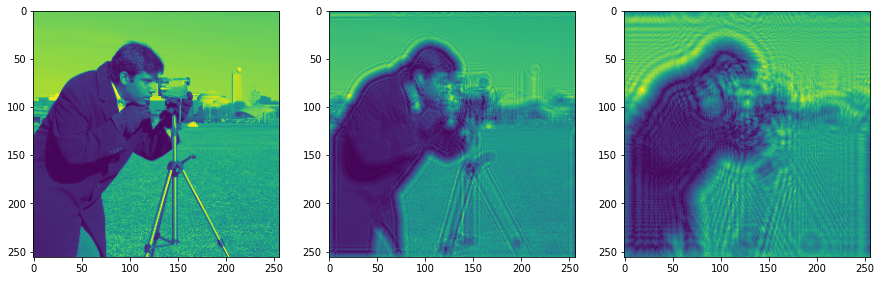

In [83]:
propagated_camera = propagator(camera,wavelength,probe_pixel_size,z1z2)
propagated_camera2 = propagator(camera,wavelength,0.5*probe_pixel_size,z1z2)
propagated_camera3 = propagator(camera,wavelength,5*probe_pixel_size,z1z2)

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(camera)
ax[1].imshow(np.abs(propagated_camera))
ax[2].imshow(np.abs(propagated_camera2))

0 0.01
1 0.012
2 0.014


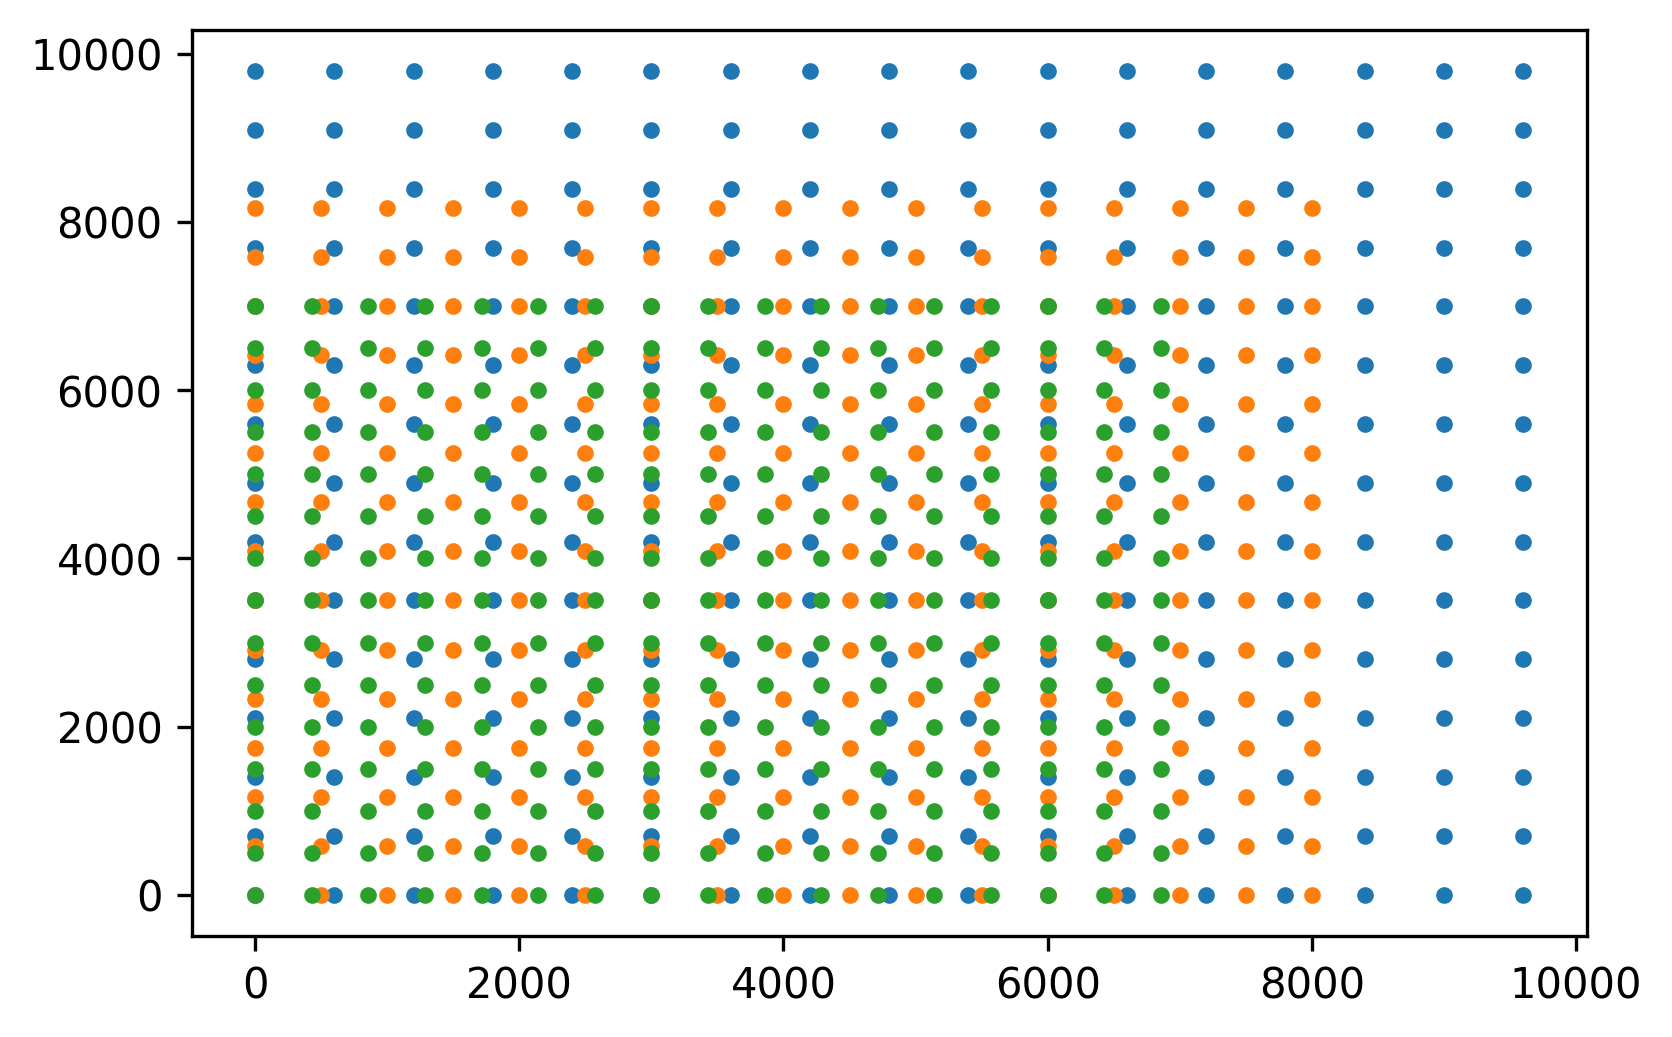

In [78]:
positions = get_positions_array(6,7,z_values,z1z2,probe.shape,plot=False)
fig, ax = plt.subplots(dpi=300)
for i in range(0,3):
    ax.plot(positions[i*255:255+i*255,0],positions[i*255:255+i*255,1],'.')

# diff_patterns, positions, positions_errors, probe_story_mask = generate_ptychography_dataset(obj,probe,positions,pixel_size,wavelength)
# diff_patterns.shape, positions.shape, obj.shape, probe.shape

In [56]:
# path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/camera_gravel_multiplane/"
# np.save(os.path.join(path,'diff_patterns.npy'),diff_patterns) # save diffraction patterns
# np.save(os.path.join(path,'positions.npy'),positions) # save positions
# np.save(os.path.join(path,'object.npy'),obj) 
# np.save(os.path.join(path,'probe.npy'),probe)